In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, jaccard_score
from sklearn import svm
from sklearn.compose import ColumnTransformer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aviakompaniya/sample_submission.csv
/kaggle/input/aviakompaniya/train_dataset.csv
/kaggle/input/aviakompaniya/test_dataset.csv


Notebook for the competition: https://www.kaggle.com/competitions/aviakompaniya/

In [2]:
df = pd.read_csv('/kaggle/input/aviakompaniya/train_dataset.csv')
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,...,4,3,1,3,4,3,4,10,3.0,0
1,2,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,...,5,5,5,5,3,5,3,0,0.0,1
2,3,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,4,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,5,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,...,4,5,2,5,3,5,4,0,10.0,0


Renaming columns

In [3]:
columns = [
    'id',
    'gender',
    'customer_type',
    'age',
    'travel_type',
    'class',
    'distance',
    'wifi',
    'time',
    'booking',
    'gate',
    'food',
    'boarding',
    'seat',
    'entertainment',
    'on_board',
    'leg_room',
    'baggage',
    'checkin',
    'inflight',
    'cleanliness',
    'departure_delay',
    'arrival_delay',
    'satisfaction'
]
df.columns = columns
df.head()

,id,gender,customer_type,age,travel_type,class,distance,wifi,time,booking,...,entertainment,on_board,leg_room,baggage,checkin,inflight,cleanliness,departure_delay,arrival_delay,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,...,4,3,1,3,4,3,4,10,3.0,0
1,2,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,...,5,5,5,5,3,5,3,0,0.0,1
2,3,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,4,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,5,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,...,4,5,2,5,3,5,4,0,10.0,0


# Exploring data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   gender           10000 non-null  object 
 2   customer_type    10000 non-null  object 
 3   age              10000 non-null  int64  
 4   travel_type      10000 non-null  object 
 5   class            10000 non-null  object 
 6   distance         10000 non-null  int64  
 7   wifi             10000 non-null  int64  
 8   time             10000 non-null  int64  
 9   booking          10000 non-null  int64  
 10  gate             10000 non-null  int64  
 11  food             10000 non-null  int64  
 12  boarding         10000 non-null  int64  
 13  seat             10000 non-null  int64  
 14  entertainment    10000 non-null  int64  
 15  on_board         10000 non-null  int64  
 16  leg_room         10000 non-null  int64  
 17  baggage      

## Cheking for duplicates

In [5]:
subset=['gender', 'customer_type', 'age', 'travel_type', 'class',
       'distance', 'wifi', 'time', 'booking', 'gate', 'food', 'boarding',
       'seat', 'entertainment', 'on_board', 'leg_room', 'baggage', 'checkin',
       'inflight', 'cleanliness', 'departure_delay', 'arrival_delay', 'satisfaction']
df.duplicated(subset=subset).sum()

486

In [6]:
df.drop_duplicates(subset=subset, inplace=True)

## Descriptive statistics

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,9514.0,4916.311226,2885.779157,1.0,2405.25,4885.5,7397.75,10000.0
age,9514.0,39.370822,14.900369,7.0,27.00,40.0,51.00,80.0
distance,9514.0,1229.935674,1021.709952,31.0,421.25,866.5,1801.75,4983.0
wifi,9514.0,2.782846,1.358226,0.0,2.00,3.0,4.00,5.0
time,9514.0,3.073891,1.522978,0.0,2.00,3.0,4.00,5.0
booking,9514.0,2.800294,1.417798,0.0,2.00,3.0,4.00,5.0
gate,9514.0,2.983393,1.281120,1.0,2.00,3.0,4.00,5.0
food,9514.0,3.213895,1.333007,0.0,2.00,3.0,4.00,5.0
boarding,9514.0,3.345701,1.353288,0.0,2.00,4.0,4.00,5.0
seat,9514.0,3.490330,1.312419,0.0,3.00,4.0,5.00,5.0


## Correlation

In [8]:
df.corr()[['satisfaction']].abs().style.background_gradient('YlGnBu')

,satisfaction
id,0.000835
age,0.141822
distance,0.302166
wifi,0.279029
time,0.068655
booking,0.165808
gate,0.009439
food,0.211445
boarding,0.503101
seat,0.343875


# Visualization

## Visualizing categorical columns

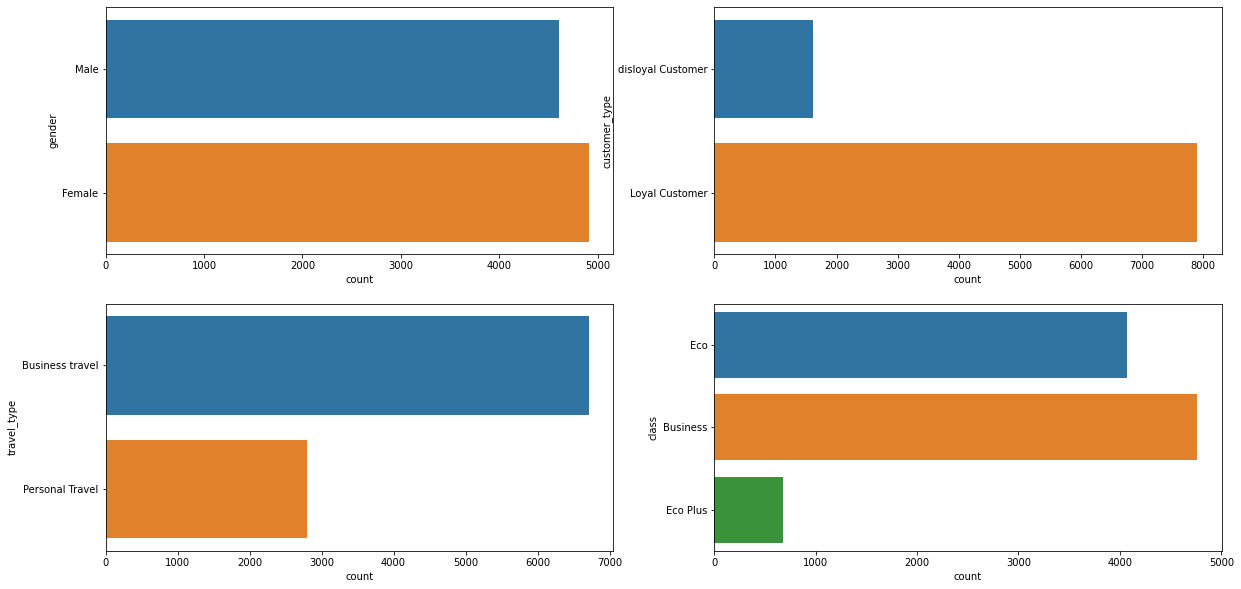

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.countplot(y=df['gender'])

plt.subplot(2,2,2)
sns.countplot(y=df['customer_type'])

plt.subplot(2,2,3)
sns.countplot(y=df['travel_type'])

plt.subplot(2,2,4)
sns.countplot(y=df['class'])
plt.show()

## Checking numerical columns for outliers

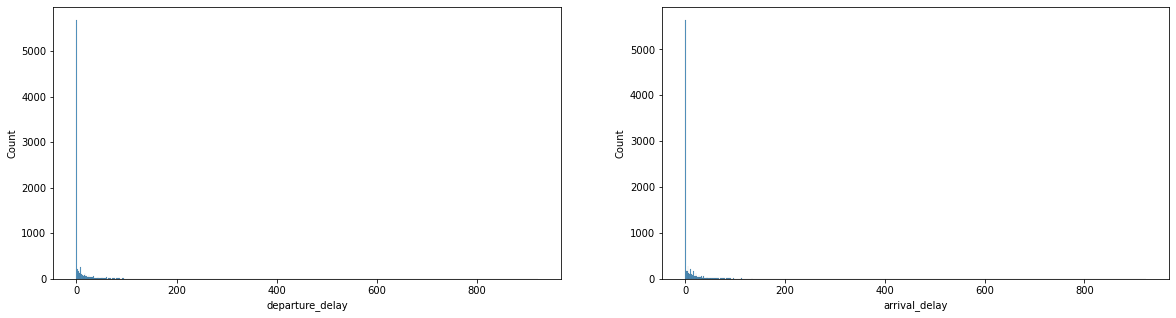

In [10]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
sns.histplot(df['departure_delay'])

plt.subplot(1,2,2)
sns.histplot(df['arrival_delay'])

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


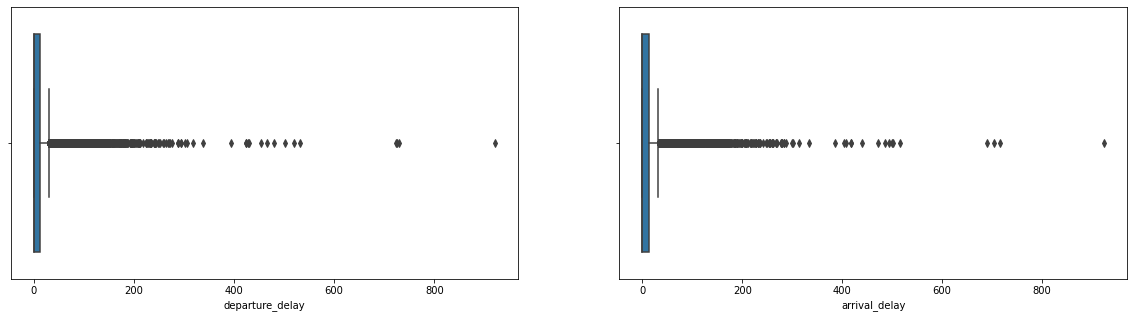

In [11]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
sns.boxplot(df['departure_delay'])

plt.subplot(1,2,2)
sns.boxplot(df['arrival_delay'])

plt.show()

In [12]:
mask = (df['arrival_delay'] > 350) & (df['departure_delay'] > 350)
len(df[mask])/len(df)*100

0.15766239226403195

> 0.157% of data are outliers.

In [13]:
df.drop(
    index=df[mask].index,
    inplace=True
)
df.isnull().sum()

id                  0
gender              0
customer_type       0
age                 0
travel_type         0
class               0
distance            0
wifi                0
time                0
booking             0
gate                0
food                0
boarding            0
seat                0
entertainment       0
on_board            0
leg_room            0
baggage             0
checkin             0
inflight            0
cleanliness         0
departure_delay     0
arrival_delay      28
satisfaction        0
dtype: int64

Filling in missing values

In [14]:
df['arrival_delay'].fillna(0, inplace=True)
df.isnull().sum().sum()

0

## Summary

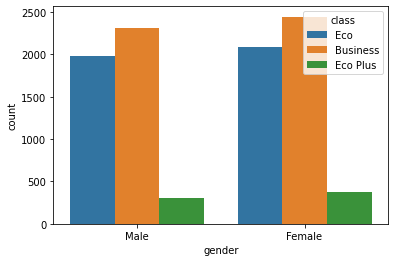

In [15]:
sns.countplot(data=df, x='gender', hue='class')
plt.show()

> The ratio of choosing flight classes does not differ by gender

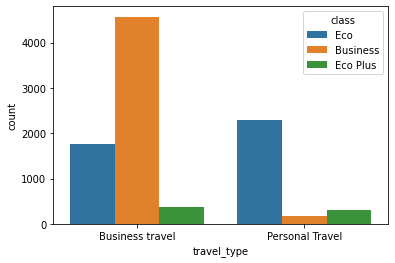

In [16]:
sns.countplot(data=df, x='travel_type', hue='class')
plt.show()

> Business travelers mostly choose business class, and personal travelers mostly choose eco class.

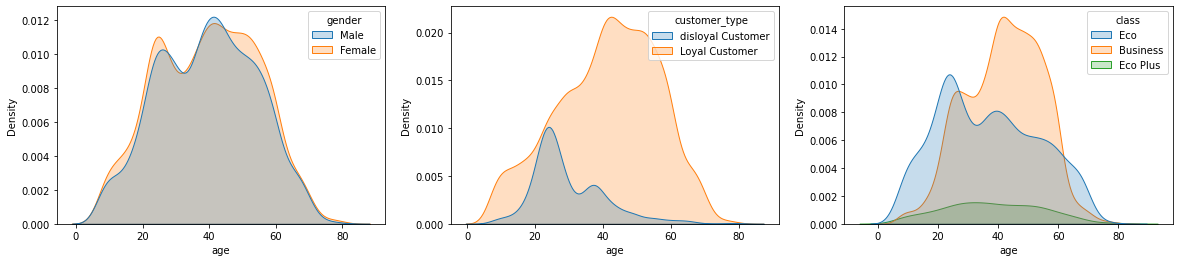

In [17]:
plt.figure(figsize=(20, 4))

plt.subplot(1,3,1)
sns.kdeplot(data=df, x='age', hue='gender', fill=True)

plt.subplot(1,3,2)
sns.kdeplot(data=df, x='age', hue='customer_type', fill=True)

plt.subplot(1,3,3)
sns.kdeplot(data=df, x='age', hue='class', fill=True)
plt.show()

> The age distribution of passengers does not differ by gender, and the majority of passengers are around 42 years old.

> Most of the loyal customers are around 42 years old, while most of the disloyal customers are around 25 years old.

> 42-year-old customers mostly choose business class, and 20-year-old customers mostly choose eco class.

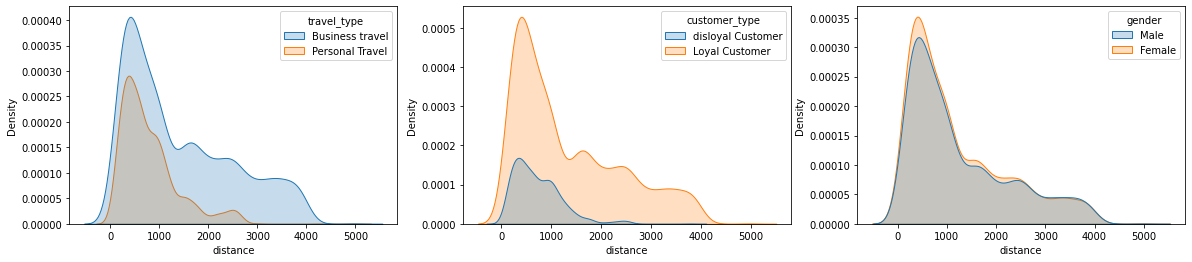

In [18]:
plt.figure(figsize=(20, 4))

plt.subplot(1,3,1)
sns.kdeplot(data=df, x='distance', hue='travel_type', fill=True)

plt.subplot(1,3,2)
sns.kdeplot(data=df, x='distance', hue='customer_type', fill=True)

plt.subplot(1,3,3)
sns.kdeplot(data=df, x='distance', hue='gender', fill=True)
plt.show()

> The majority of customers usually travel distances of around 500km, regardless of travel type, loyalty and gender.

# Machine learning

## Preparing

In [19]:
encoder = LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])
df['customer_type'] = encoder.fit_transform(df['customer_type'])
df['travel_type'] = encoder.fit_transform(df['travel_type'])
df['class'] = encoder.fit_transform(df['class'])

Getting rid of low correlated columns

In [20]:
X = df[['gender', 'customer_type', 'travel_type', 'class',
       'distance', 'wifi', 'food', 'boarding',
       'seat', 'entertainment', 'on_board', 'leg_room', 'baggage', 'checkin',
       'inflight', 'cleanliness']].values

In [21]:
y = df['satisfaction'].values

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Training

Decision Tree

In [23]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_predict = tree_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       965
           1       0.93      0.92      0.93       935

    accuracy                           0.93      1900
   macro avg       0.93      0.93      0.93      1900
weighted avg       0.93      0.93      0.93      1900

Accuracy:  0.9273684210526316
Precision:  0.9308108108108109
Recall:  0.9208556149732621
F1:  0.9258064516129032
Jaccard:  0.8618618618618619


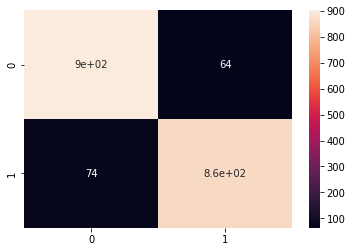

In [24]:
# Evaluating
print(classification_report(y_test, y_predict))
print("Accuracy: ", accuracy_score(y_test, y_predict))
print("Precision: ", precision_score(y_test, y_predict))
print("Recall: ", recall_score(y_test, y_predict))
print("F1: ", f1_score(y_test, y_predict))
print("Jaccard: ", jaccard_score(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

In [25]:
# Evaluating with cross-validation
predict = cross_val_predict(estimator = tree_model, X = X, y = y, cv = 5)
print(classification_report(y, predict))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4780
           1       0.92      0.92      0.92      4719

    accuracy                           0.92      9499
   macro avg       0.92      0.92      0.92      9499
weighted avg       0.92      0.92      0.92      9499



Random Forest

In [26]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_predict = rf_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       965
           1       0.96      0.93      0.95       935

    accuracy                           0.95      1900
   macro avg       0.95      0.95      0.95      1900
weighted avg       0.95      0.95      0.95      1900

Accuracy:  0.9478947368421052
Precision:  0.9613686534216336
Recall:  0.9315508021390374
F1:  0.9462248777838131
Jaccard:  0.8979381443298969


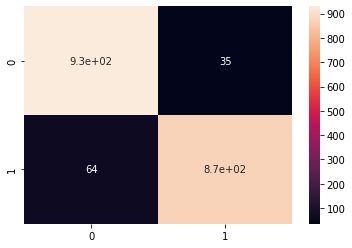

In [27]:
# Evaluating
print(classification_report(y_test, y_predict))
print("Accuracy: ", accuracy_score(y_test, y_predict))
print("Precision: ", precision_score(y_test, y_predict))
print("Recall: ", recall_score(y_test, y_predict))
print("F1: ", f1_score(y_test, y_predict))
print("Jaccard: ", jaccard_score(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

In [28]:
# Evaluating with cross-validation
predict = cross_val_predict(estimator = rf_model, X = X, y = y, cv = 5)
print(classification_report(y, predict))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4780
           1       0.95      0.93      0.94      4719

    accuracy                           0.95      9499
   macro avg       0.95      0.95      0.95      9499
weighted avg       0.95      0.95      0.95      9499



SVC

In [29]:
svc_model = svm.SVC()
svc_model.fit(X_train, y_train)
y_predict = svc_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       965
           1       0.94      0.92      0.93       935

    accuracy                           0.94      1900
   macro avg       0.94      0.94      0.94      1900
weighted avg       0.94      0.94      0.94      1900

Accuracy:  0.9352631578947368
Precision:  0.9432314410480349
Recall:  0.9240641711229947
F1:  0.93354943273906
Jaccard:  0.8753799392097265


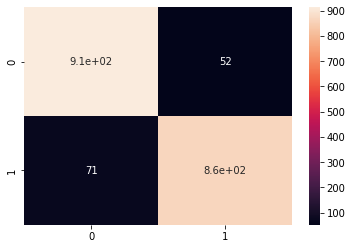

In [30]:
# Evaluating
print(classification_report(y_test, y_predict))
print("Accuracy: ", accuracy_score(y_test, y_predict))
print("Precision: ", precision_score(y_test, y_predict))
print("Recall: ", recall_score(y_test, y_predict))
print("F1: ", f1_score(y_test, y_predict))
print("Jaccard: ", jaccard_score(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

In [31]:
# Evaluating with cross-validation
predict = cross_val_predict(estimator = svc_model, X = X, y = y, cv = 5)
print(classification_report(y, predict))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70      4780
           1       0.72      0.47      0.57      4719

    accuracy                           0.65      9499
   macro avg       0.66      0.64      0.63      9499
weighted avg       0.66      0.65      0.63      9499



GradientBoostingClassifier

In [32]:
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=0)
gbc_model.fit(X_train, y_train)
y_predict = gbc_model.predict(X_test)
gbc_model.score(X_test, y_test)

0.9478947368421052

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       965
           1       0.96      0.93      0.95       935

    accuracy                           0.95      1900
   macro avg       0.95      0.95      0.95      1900
weighted avg       0.95      0.95      0.95      1900

Accuracy:  0.9478947368421052
Precision:  0.9583333333333334
Recall:  0.9347593582887701
F1:  0.9463995668651869
Jaccard:  0.8982528263103803


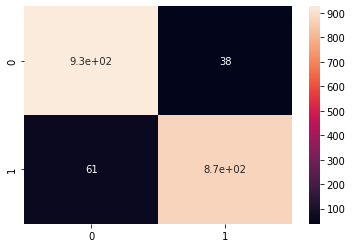

In [33]:
# Evaluating
print(classification_report(y_test, y_predict))
print("Accuracy: ", accuracy_score(y_test, y_predict))
print("Precision: ", precision_score(y_test, y_predict))
print("Recall: ", recall_score(y_test, y_predict))
print("F1: ", f1_score(y_test, y_predict))
print("Jaccard: ", jaccard_score(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

In [34]:
# Evaluating with cross-validation
predict = cross_val_predict(estimator = gbc_model, X = X, y = y, cv = 5)
print(classification_report(y, predict))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4780
           1       0.95      0.94      0.94      4719

    accuracy                           0.94      9499
   macro avg       0.94      0.94      0.94      9499
weighted avg       0.94      0.94      0.94      9499



In [35]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_predict = knn_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       965
           1       0.92      0.85      0.88       935

    accuracy                           0.89      1900
   macro avg       0.89      0.89      0.89      1900
weighted avg       0.89      0.89      0.89      1900

Accuracy:  0.8894736842105263
Precision:  0.9220023282887078
Recall:  0.8470588235294118
F1:  0.882943143812709
Jaccard:  0.7904191616766467


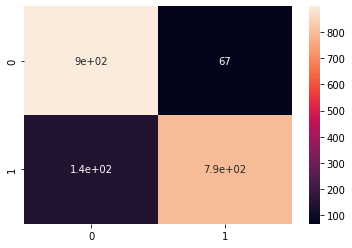

In [36]:
# Evaluating
print(classification_report(y_test, y_predict))
print("Accuracy: ", accuracy_score(y_test, y_predict))
print("Precision: ", precision_score(y_test, y_predict))
print("Recall: ", recall_score(y_test, y_predict))
print("F1: ", f1_score(y_test, y_predict))
print("Jaccard: ", jaccard_score(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

In [37]:
# Evaluating with cross-validation
predict = cross_val_predict(estimator = knn_model, X = X, y = y, cv = 5)
print(classification_report(y, predict))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      4780
           1       0.76      0.74      0.75      4719

    accuracy                           0.76      9499
   macro avg       0.76      0.76      0.76      9499
weighted avg       0.76      0.76      0.76      9499



# Submission

In [38]:
submission = pd.read_csv('/kaggle/input/aviakompaniya/test_dataset.csv')

In [39]:
# Preparing
submission.columns = columns[:-1]

submission['gender'] = encoder.fit_transform(submission['gender'])
submission['customer_type'] = encoder.fit_transform(submission['customer_type'])
submission['travel_type'] = encoder.fit_transform(submission['travel_type'])
submission['class'] = encoder.fit_transform(submission['class'])

X = submission[['gender', 'customer_type', 'travel_type', 'class',
       'distance', 'wifi', 'food', 'boarding',
       'seat', 'entertainment', 'on_board', 'leg_room', 'baggage', 'checkin',
       'inflight', 'cleanliness']].values
X = scaler.fit_transform(X)

In [40]:
# Prediction
y = gbc_model.predict(X)

In [41]:
submission_file = pd.read_csv("/kaggle/input/aviakompaniya/sample_submission.csv")
submission_file['satisfaction'] = y
submission_file.to_csv("submission.csv", index=False)